# Constrained Transporter: Visualize FVA CF Results #

In [1]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import warnings
import os
import pycomo

sb.set_theme()

2025-11-17 15:55:24,391 - pycomo - INFO - Logger initialized.
2025-11-17 15:55:24,394 - pycomo - INFO - Process Pool Logger initialized.
2025-11-17 15:55:24,394 - pycomo - INFO - Utils Logger initialized.
2025-11-17 15:55:24,396 - pycomo - INFO - Multiprocess Logger initialized.


## Load all DataFrames and Concatenate them ##

In [2]:
model_path = "data/community_models/M. smithii_B. thetaiotaomicron_ms_open_min_med_tp_10.xml"
model = pycomo.CommunityModel.load(model_path)

In [26]:
def extract_cross_feeding_from_fva(fva_result):
    rows = []
    df = fva_result.copy()
    def list_without_element(list_var, element):
        """
        Returns a copy of a list without the specified element.
    
        :param list_var: List whose element should be excluded
        :param element: Element to be excluded
        :return: A list without target element
        """
        list_var = list_var.copy()
        list_var.remove(element)
        return list_var

    def close_to_zero(num, t=10**-10):
        """
        Checks whether a number is within threshold t of 0. Default threshold t is the solver tolerance.
    
        :param num: The number to be checked
        :param t: The threshold around 0
        :return: True if the number is within threshold t of 0, otherwise False
        """
        return -t < num < t
        
    def extract_met_from_rxn_id(rxn_id):
        rxn_splits = rxn_id.split("_")
        for rxn_split in rxn_splits:
            if "cpd" == rxn_split[:3]:
                return rxn_split
        return "unknown"
    df["met"] = df["reaction_id"].apply(extract_met_from_rxn_id)
    exchg_metabolites = df["met"].unique()

    df["member"] = df["reaction_id"].apply(lambda x: x.split("_TF_")[0] if "_TF_" in x else "None")
    member_names = list(df["member"].unique())
    member_names.remove("None")

    columns = ["metabolite_id", "cross_feeding", "MtB", "BtM", "bidirectional"]
    for name in member_names:
        columns.append(name + "_min_flux")
        columns.append(name + "_max_flux")

    for exchg_met in exchg_metabolites:
        # Check flux of transfer ("_TF_") reactions to organism
        row_dict = {"metabolite_id": exchg_met, "cross_feeding": False}
        for name in member_names:
            row_dict[name + "_min_flux"] = 0.
            row_dict[name + "_max_flux"] = 0.
            
            try:
                target_row = df.loc[(df['member'] == name) & (df["met"] == exchg_met)].iloc[0]

                min_flux = float(target_row["min_flux"])
                max_flux = float(target_row["max_flux"])
                row_dict[name + "_min_flux"] = 0. if close_to_zero(min_flux) else min_flux
                row_dict[name + "_max_flux"] = 0. if close_to_zero(max_flux) else max_flux
            except IndexError:
                continue
        interaction = False
        interactions = {"MtB":0, "BtM":0}
        for name in member_names:
            if row_dict[name + "_min_flux"] < 0. and any(
                    [row_dict[other + "_max_flux"] > 0. for other in list_without_element(member_names, name)]):
                interaction = True
                if name[0] == "A":
                    interactions["BtM"] = 1
                else:
                    interactions["MtB"] = 1
        row_dict["cross_feeding"] = interaction
        row_dict["MtB"] = interactions["MtB"]
        row_dict["BtM"] = interactions["BtM"]
        row_dict["bidirectional"] = 1 if interactions["MtB"] and interactions["BtM"] else 0
        rows.append(row_dict)

    exchg_metabolite_df = pd.DataFrame(rows, columns=columns)

    return exchg_metabolite_df

In [27]:
to_concat = []
for file in ["data/flux_vectors/fva_0.1_m_smithii_btim_msmithii_min_med_tp_10.csv", 
             "data/flux_vectors/fva_0.25_m_smithii_btim_msmithii_min_med_tp_10.csv",
             "data/flux_vectors/fva_max_growth_m_smithii_btim_msmithii_min_med_tp_10.csv",
             "data/flux_vectors/fva_0.75_m_smithii_btim_msmithii_min_med_tp_10.csv",
             "data/flux_vectors/fva_0.9_m_smithii_btim_msmithii_min_med_tp_10.csv",]:
    tp = float(file.split("_")[-1].split(".")[0])
    fva_split = file.split("_")[2]
    gamma = float(fva_split) if not "max" == fva_split else 0.48
    df = pd.read_csv(file, sep=",") 
    cf_df = extract_cross_feeding_from_fva(df)
    cf_df["transport_bounds"] = tp
    cf_df["fraction M. smithii"] = gamma
    cf_df["cf_bin"] = cf_df["cross_feeding"].apply(lambda x: 1 if x else 0)
    to_concat.append(cf_df)
    
df_concat = pd.concat(to_concat)

In [28]:
df_concat["metabolite_name_unique"] = df_concat["metabolite_id"].apply(lambda x: x + "_" + model.model.metabolites.query(lambda y: y.compartment == "medium" and x in y.id)[0].name
                                                               if x[:3] == "cpd" else x + "_" + "biomass")


In [29]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 199
Data columns (total 13 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   metabolite_id                                     1000 non-null   object 
 1   cross_feeding                                     1000 non-null   bool   
 2   MtB                                               1000 non-null   int64  
 3   BtM                                               1000 non-null   int64  
 4   bidirectional                                     1000 non-null   int64  
 5   ABYW00000000_1_ms_medium_gapseq_open_min_flux     1000 non-null   float64
 6   ABYW00000000_1_ms_medium_gapseq_open_max_flux     1000 non-null   float64
 7   NC_004663_1_ms_b_tim_medium_gapseq_open_min_flux  1000 non-null   float64
 8   NC_004663_1_ms_b_tim_medium_gapseq_open_max_flux  1000 non-null   float64
 9   transport_bounds         

In [30]:
df_concat.head()

,metabolite_id,cross_feeding,MtB,BtM,bidirectional,ABYW00000000_1_ms_medium_gapseq_open_min_flux,ABYW00000000_1_ms_medium_gapseq_open_max_flux,NC_004663_1_ms_b_tim_medium_gapseq_open_min_flux,NC_004663_1_ms_b_tim_medium_gapseq_open_max_flux,transport_bounds,fraction M. smithii,cf_bin,metabolite_name_unique
0,cpd00001,True,1,0,0,1.0,1.0,-1.0,-1.0,10.0,0.1,1,cpd00001_H2O
1,cpd03247,False,0,0,0,0.0,0.0,0.0,0.0,10.0,0.1,0,cpd03247_Glycochenodeoxycholate
2,cpd00033,False,0,0,0,0.0,0.0,0.0,0.0,10.0,0.1,0,cpd00033_Glycine
3,cpd01663,False,0,0,0,0.0,0.0,0.0,0.0,10.0,0.1,0,cpd01663_Chenodiol
4,cpd01318,False,0,0,0,0.0,0.0,0.0,0.0,10.0,0.1,0,cpd01318_Glycocholate


In [31]:
df_concat["cf_label"] = df_concat.apply(lambda row: 3 if row["bidirectional"] else (2 if row["BtM"] else (1 if row["MtB"] else 0)), axis=1)

## Prepare features ##

In [32]:
min_medium = pd.read_csv("data/media/minimal_medium_community.csv")
min_medium.columns = ["met_id", "met_name", "flux"]
min_medium

,met_id,met_name,flux
0,cpd00009,Phosphate,1000
1,cpd00030,Mn2+,1000
2,cpd00034,Zn2+,1000
3,cpd00051,L-Arginine,1000
4,cpd00119,L-Histidine,1000
5,cpd00149,Co2+,1000
6,cpd00244,Ni2+,1000
7,cpd10516,fe3,1000
8,cpd00084,L-Cysteine,1000
9,cpd00063,Ca2+,1000


In [33]:
df_concat["in_medium"] = df_concat["metabolite_id"].apply(lambda x: x in min_medium["met_id"])

In [34]:
df_concat.head()

,metabolite_id,cross_feeding,MtB,BtM,bidirectional,ABYW00000000_1_ms_medium_gapseq_open_min_flux,ABYW00000000_1_ms_medium_gapseq_open_max_flux,NC_004663_1_ms_b_tim_medium_gapseq_open_min_flux,NC_004663_1_ms_b_tim_medium_gapseq_open_max_flux,transport_bounds,fraction M. smithii,cf_bin,metabolite_name_unique,cf_label,in_medium
0,cpd00001,True,1,0,0,1.0,1.0,-1.0,-1.0,10.0,0.1,1,cpd00001_H2O,1,False
1,cpd03247,False,0,0,0,0.0,0.0,0.0,0.0,10.0,0.1,0,cpd03247_Glycochenodeoxycholate,0,False
2,cpd00033,False,0,0,0,0.0,0.0,0.0,0.0,10.0,0.1,0,cpd00033_Glycine,0,False
3,cpd01663,False,0,0,0,0.0,0.0,0.0,0.0,10.0,0.1,0,cpd01663_Chenodiol,0,False
4,cpd01318,False,0,0,0,0.0,0.0,0.0,0.0,10.0,0.1,0,cpd01318_Glycocholate,0,False


In [35]:
df_concat["metabolite_name_unique"].value_counts()

metabolite_name_unique
cpd00001_H2O                       5
cpd03247_Glycochenodeoxycholate    5
cpd00033_Glycine                   5
cpd01663_Chenodiol                 5
cpd01318_Glycocholate              5
                                  ..
cpd00232_Neu5Ac                    5
cpd03047_Taurocholate              5
cpd00152_Agmatine                  5
cpd00006_NADP                      5
cpd03246_Taurochenodeoxycholate    5
Name: count, Length: 200, dtype: int64

In [36]:
df_concat["metabolite_name"] = df_concat["metabolite_name_unique"].apply(lambda x: x.split("_")[1])

In [37]:
df = df_concat.loc[~df_concat["in_medium"]].pivot(index="metabolite_name_unique", columns="fraction M. smithii", values="cf_label")
df.head()

fraction M. smithii,0.10,0.25,0.48,0.75,0.90
metabolite_name_unique,,,,,
cpd00001_H2O,1,1,1,1,1
cpd00003_NAD,2,2,2,2,2
cpd00006_NADP,0,0,0,0,0
cpd00007_O2,0,0,0,0,0
cpd00009_Phosphate,0,0,0,0,0


In [38]:
df_trim = df.loc[df.apply(lambda row: not (all([x == 0 for x in row])), axis=1)]
df_trim

fraction M. smithii,0.10,0.25,0.48,0.75,0.90
metabolite_name_unique,,,,,
cpd00001_H2O,1,1,1,1,1
cpd00003_NAD,2,2,2,2,2
cpd00010_CoA,2,2,2,2,2
cpd00013_NH3,1,1,1,1,2
cpd00027_D-Glucose,0,0,0,2,2
cpd00035_L-Alanine,1,1,1,3,1
cpd00039_L-Lysine,2,2,2,2,1
cpd00047_Formate,2,2,3,2,2
cpd00053_L-Glutamine,2,2,2,2,2


## Plot cross-fed metabolites ##

<class 'matplotlib.colorbar.Colorbar'>


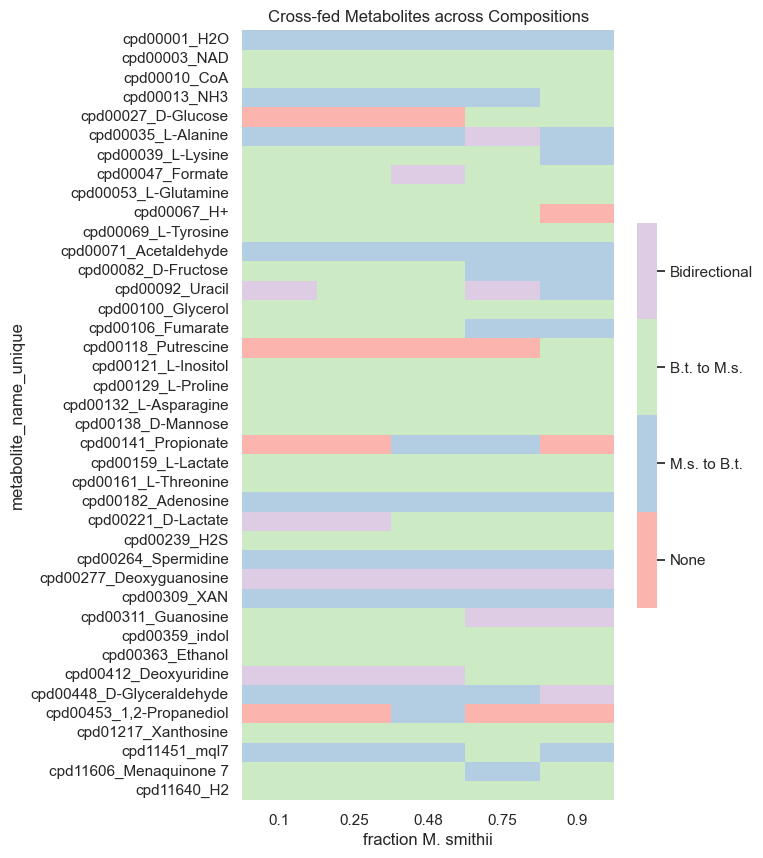

In [39]:
ax = sb.heatmap(df_trim, yticklabels=1, cmap=sb.color_palette("Pastel1", 4), cbar_kws={'shrink': 0.5, 'aspect': 20})
f = plt.gcf()
# modify colorbar:
colorbar = ax.collections[0].colorbar 
print(colorbar)
print(type(colorbar))
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / 4 * (0.5 + i) for i in range(4)])
colorbar.set_ticklabels(["None", "M.s. to B.t.", "B.t. to M.s.", "Bidirectional"]) 
plt.title("Cross-fed Metabolites across Compositions")
f.set_size_inches(6,10)

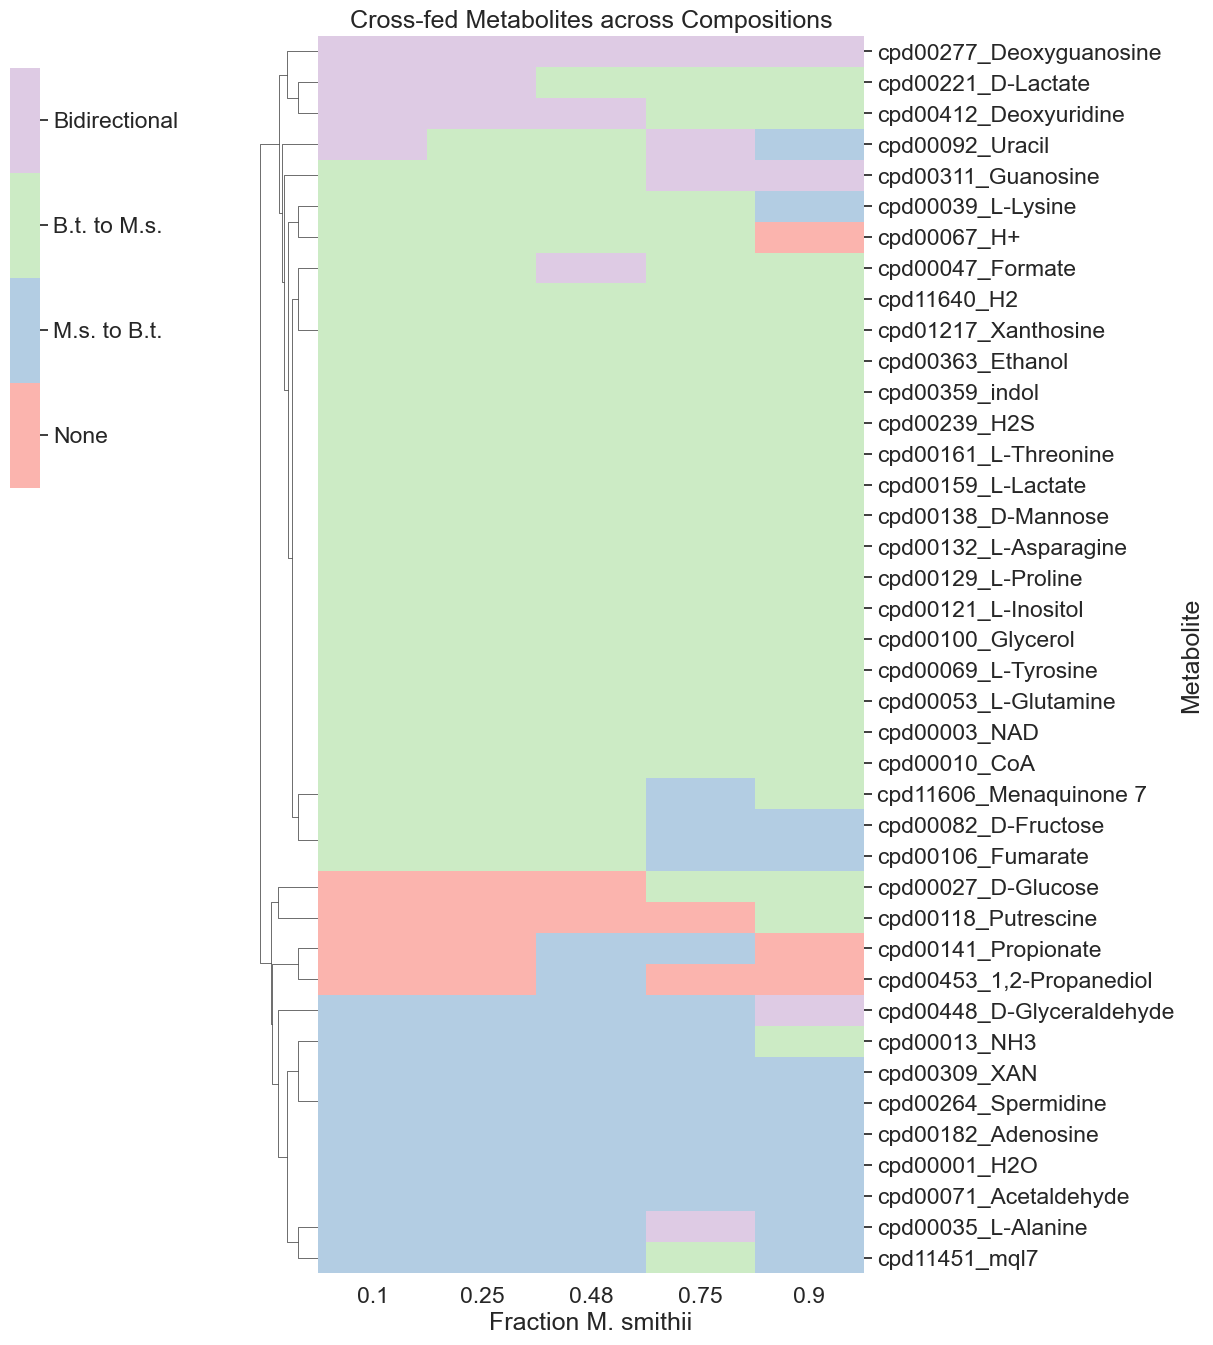

In [44]:
sb.set(font_scale=1.5)

g = sb.clustermap(df_trim, col_cluster=False, cmap=sb.color_palette("Pastel1", 4), dendrogram_ratio=(.1, 0.), cbar_pos=(-0.22, .65, .03, .3), yticklabels=1)
f = plt.gcf()
x0, _y0, _w, _h = g.cbar_pos
colorbar = g.ax_cbar

r = _h*10
colorbar.set_yticks([0 + r / 4 * (0.5 + i) for i in range(4)])
colorbar.set_yticklabels(["None", "M.s. to B.t.", "B.t. to M.s.", "Bidirectional"]) 
ax = g.ax_heatmap
ax.set_ylabel("Metabolite")
ax.set_xlabel("Fraction M. smithii")
ax.set_title("Cross-fed Metabolites across Compositions")
f.set_size_inches(10,14)
plt.savefig("figures/cf_heatmap_min_med.png", bbox_inches="tight")